# Probabilistic Forecasting: Conformal Calibration

Conformal prediction is a framework for constructing prediction intervals that are guaranteed to contain the true value with a specified probability (coverage probability). In addition to generating prediction intervals from point forecasts, conformal methods can also calibrate prediction intervals generated by other techniques, such as quantile regression or bootstrapped residuals. In this case, the conformal method adjusts the prediction intervals to ensure they remain valid with respect to the coverage probability. Skforecast provides this functionality through the `ConformalIntervalCalibrator` transformer that can be used for single series forecasting models as well as global forecasting models.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>For more examples on how to use probabilistic forecasting, check out the following articles:</p>
<ul>
    <li>
        <a href="https://cienciadedatos.net/documentos/py42-probabilistic-forecasting" target="_blank">
            Probabilistic forecasting with machine learning
        </a>
    </li>
    <li>
        <a href="https://cienciadedatos.net/documentos/py60-probabilistic-forecasting-prediction-intervals-multi-step-forecasting" target="_blank">
            Probabilistic forecasting: prediction intervals for multi-step time series forecasting
        </a>
    </li>
    <li>
        <a href="../faq/probabilistic-forecasting-crps-score.html" target="_blank">
            Continuous Ranked Probability Score (CRPS) in probabilistic forecasting
        </a>
    </li>
</ul>


</div>

In [8]:
# Data processing
# ==============================================================================
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
from skforecast.plot import plot_prediction_intervals

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursive, ForecasterRecursiveMultiSeries
from skforecast.preprocessing import ConformalIntervalCalibrator
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster, backtesting_forecaster_multiseries
from skforecast.metrics import calculate_coverage

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

## Calibrate intervals using conformal methods

To understand how calibration works, a interval with a coverage of 60% is simulated.

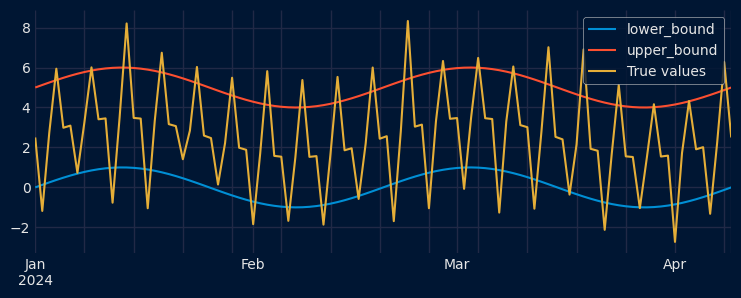

In [18]:
# Simulation of interval with coverage of 63%
# ==============================================================================
rng = np.random.default_rng(42)
interval = pd.DataFrame({
        'lower_bound': np.sin(np.linspace(0, 4 * np.pi, 100)),
        'upper_bound': np.sin(np.linspace(0, 4 * np.pi, 100)) + 5
    },
    index=pd.date_range(start='2024-01-01', periods=100, freq='D')
)
y_true = (interval['lower_bound'] + interval['upper_bound']) / 2
y_true.name = "series_1"
y_true.iloc[1::5] = interval.iloc[1::5, 0] - rng.normal(1, 1, 20)
y_true.iloc[3::5] = interval.iloc[1::5, 1] + rng.normal(1, 1, 20)

set_dark_theme()
fig, ax = plt.subplots(figsize=(8, 3))
interval.plot(ax=ax)
y_true.plot(ax=ax, label='True values')
ax.legend(loc='upper right');

In [20]:
coverage = calculate_coverage(
    y_true=y_true,
    lower_bound=interval["lower_bound"],
    upper_bound=interval["upper_bound"],
)
print(f'Coverage: {coverage:.2f}')

Coverage: 0.63


The interval has a coverage of 63%, which means that the true values are within the interval 63% of the time. Next, the `ConformalIntervalCalibrator` transformer is used to calibrate the prediction interval to ensure that it has a coverage of 80%.

In [21]:
# Create and fit ConformalIntervalCalibrator
# ==============================================================================
calibrator = ConformalIntervalCalibrator(nominal_coverage=0.8)
calibrator.fit(y_true=y_true, y_pred_interval=interval)
calibrator

The correction factor of 1.034 means that the interval needs to be expanded by 1.034 units in each direction to achieve the desired coverage of 80%.

In [23]:
interval_calibrated = calibrator.transform(interval)
interval_calibrated = interval_calibrated.rename(
    columns={
        "lower_bound": "lower_bound_calibrated",
        "upper_bound": "upper_bound_calibrated",
    }
)
interval_calibrated.head(3)

,lower_bound_calibrated,upper_bound_calibrated
2024-01-01,-1.034244,6.034244
2024-01-02,-0.907651,6.160836
2024-01-03,-0.783096,6.285392


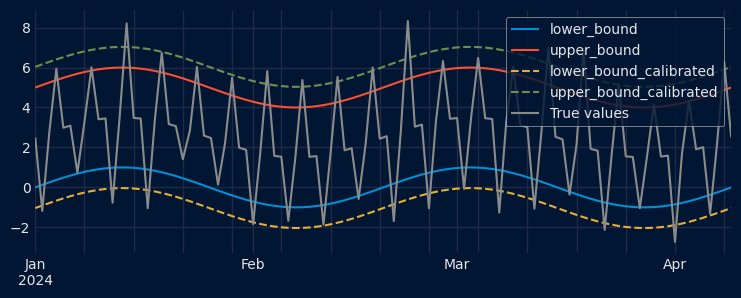

In [24]:
fig, ax = plt.subplots(figsize=(8, 3))
interval.plot(ax=ax)
interval_calibrated.plot(ax=ax, linestyle="--")
y_true.plot(ax=ax, label="True values")
ax.legend(loc="upper right");

In [26]:
coverage = calculate_coverage(
    y_true=y_true,
    lower_bound=interval_calibrated["lower_bound_calibrated"],
    upper_bound=interval_calibrated["upper_bound_calibrated"],
)
print(f"Coverage: {coverage:.2f}")

Coverage: 0.80


After calibration, the coverage is 80% as expected. The interval is wider than the original one.

## Calibration of single series models

A `ForecasterAutoreg` model is used to forecast prediction intervals with the bootstrapped residuals method. A `ConformalIntervalCalibrator` transformer is then used to calibrate the prediction intervals to ensure they have the desired coverage probability.

In [3]:
# Data download
# ==============================================================================
data = fetch_dataset(name='bike_sharing', raw=False)
data = data[['users', 'temp', 'hum', 'windspeed', 'holiday']]
data = data.loc['2011-04-01 00:00:00':'2012-10-20 23:00:00', :].copy()
data.head(3)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 11)


,users,temp,hum,windspeed,holiday
date_time,,,,,
2011-04-01 00:00:00,6.0,10.66,100.0,11.0014,0.0
2011-04-01 01:00:00,4.0,10.66,100.0,11.0014,0.0
2011-04-01 02:00:00,7.0,10.66,93.0,12.9980,0.0


In [4]:
# Split data into: train-calibration-test
# ==============================================================================
end_train = '2012-06-30 23:59:00'
end_calibration = '2012-09-20 23:59:00'
data_train = data.loc[: end_train, :]
data_cal   = data.loc[end_train:end_calibration, :]
data_test  = data.loc[end_calibration:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates calibration: {data_cal.index.min()} --- {data_cal.index.max()}  (n={len(data_cal)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-04-01 00:00:00 --- 2012-06-30 23:00:00  (n=10968)
Dates calibration: 2012-07-01 00:00:00 --- 2012-09-20 23:00:00  (n=1968)
Dates test       : 2012-09-21 00:00:00 --- 2012-10-20 23:00:00  (n=720)


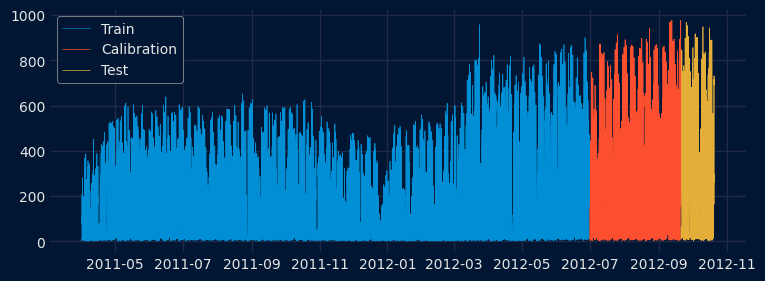

In [5]:
# Plot partitions
# ==============================================================================
set_dark_theme()
plt.rcParams['lines.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['users'], label='Train')
ax.plot(data_cal['users'], label='Calibration')
ax.plot(data_test['users'], label='Test')
ax.legend();

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

<p>In this example, the data is divided into three partitions:</p>
<ul>
    <li>Training: Used to train the model.</li><br>
    <li>Calibration: Used to determine the correction factor needed to calibrate the prediction intervals.</li><br>
    <li>Test: Used to evaluate the model’s predictions.</li><br>
</ul>
<p>If hyperparameter optimization or feature selection is required, a fourth partition should be used for validation.</p>

</div>

Prediction intervals are calculated for the test set using the bootstrapped residuals method with in-sample residuals.

In [6]:
# Create forecaster
# ==============================================================================
params = {
    "max_depth": 4,
    "n_estimators": 50,
    "verbose": -1,
    "random_state": 15926
}
lags = [1, 2, 3, 23, 24, 25, 167, 168, 169]

forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(**params),
                 lags      = lags,
             )

In [7]:
# Backtesting with prediction intervals in test data using in-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_calibration]),
         refit              = False
     )

metric, predictions_test = backtesting_forecaster(
                               forecaster              = forecaster,
                               y                       = data['users'],
                               cv                      = cv,
                               metric                  = 'mean_absolute_error',
                               interval                = [10, 90],  # 80% prediction interval
                               interval_method         = 'bootstrapping',
                               n_boot                  = 150,
                               use_in_sample_residuals = True,  # Use in-sample residuals
                               verbose                 = False,
                               show_progress           = True
                           )
predictions_test.head(5)

  0%|          | 0/30 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-09-21 00:00:00,101.022472,57.559067,140.548647
2012-09-21 01:00:00,62.635418,9.923747,120.054661
2012-09-21 02:00:00,31.062836,-4.171899,105.837602
2012-09-21 03:00:00,15.166505,-23.093901,90.417774
2012-09-21 04:00:00,14.567935,-20.391165,116.394357


Coverage: 63.75 %
Area: 93357.29


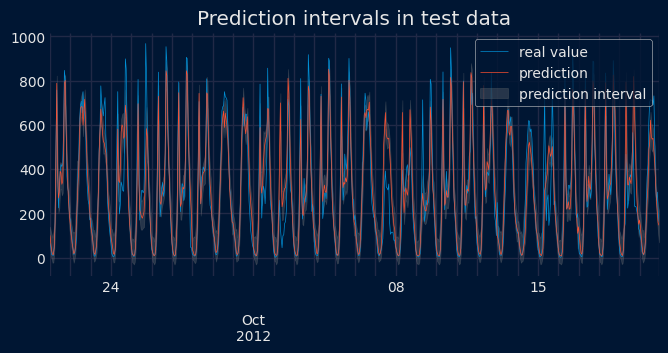

In [8]:
# Predicted interval coverage and area (on test data)
# ==============================================================================
coverage = calculate_coverage(
               y_true      = data.loc[end_calibration:, 'users'],
               lower_bound = predictions_test["lower_bound"], 
               upper_bound = predictions_test["upper_bound"]
           )
area = (predictions_test["upper_bound"] - predictions_test["lower_bound"]).sum()
print(f"Coverage: {round(100 * coverage, 2)} %")
print(f"Area: {round(area, 2)}")

# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions         = predictions_test,
    y_true              = data_test,
    target_variable     = "users",
    title               = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
)

As expected, since in-sample residuals are used, the prediction intervals are too narrow and do not achieve the desired coverage probability of 80%.

Conformal methods allow to calibrate prediction intervals generated by other techniques, such as quantile regression or bootstrapped residuals. The `ConformalIntervalCalibrator` transformer uses the [Split Conformal Prediction (SCP)](https://mapie.readthedocs.io/en/stable/theoretical_description_regression.html#the-split-method) method to learn the correction factor needed to expand or shrink the prediction intervals to ensure they are valid with respect to a given coverage probability.


First, the prediction intervals are estimated for the calibration set. Then, using the predicted intervals and the actual values of the calibration set, the `ConformalIntervalCalibrator` transformer learns the correction factor needed to calibrate the prediction intervals. Finally, the prediction intervals for the test set are calibrated using the correction factor learned from the calibration set.

In [9]:
# Predict intervals for the calibration set
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_train]),
         refit              = False
     )

_, predictions_cal = backtesting_forecaster(
                         forecaster              = forecaster,
                         y                       = data.loc[:end_calibration, 'users'],
                         cv                      = cv,
                         metric                  = 'mean_absolute_error',
                         interval                = [10, 90],  # 80% prediction interval
                         interval_method         = 'bootstrapping',
                         n_boot                  = 150,
                         use_in_sample_residuals = True,  # Use in-sample residuals
                         verbose                 = False,
                         show_progress           = True
                     )

predictions_cal.head(5)

  0%|          | 0/82 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-07-01 00:00:00,122.616496,78.160110,164.875300
2012-07-01 01:00:00,113.028788,60.884234,163.170071
2012-07-01 02:00:00,94.070085,43.273511,153.300596
2012-07-01 03:00:00,62.357389,7.609925,130.466201
2012-07-01 04:00:00,26.752876,-19.774017,109.357772


In [10]:
# Fit a ConformalIntervalCalibrator transformer using the calibration set
# ==============================================================================
conformal_interval = ConformalIntervalCalibrator(nominal_coverage=0.8)
conformal_interval.fit(
    y_true          = data.loc[predictions_cal.index, 'users'],
    y_pred_interval = predictions_cal[['lower_bound', 'upper_bound']]
)
conformal_interval

ConformalIntervalCalibrator 
Nominal coverage: 0.8 
Correction factor: {'users': 38.44337182009968} 
Fitted series: ['users'] 

The correction factor is is positive, which means that the prediction intervals are too narrow and need to be expanded to achieve the desired coverage probability. Finally, the previously predicted intervals of the test set are calibrated.

In [11]:
# Calibrate prediction intervals of the test set
# ==============================================================================
predictions_test_calibrated = conformal_interval.transform(
                                predictions_test[["lower_bound", "upper_bound"]]
                              )
predictions_test_calibrated.head(3)

,level,lower_bound,upper_bound
2012-09-21 00:00:00,users,19.115695,178.992019
2012-09-21 01:00:00,users,-28.519625,158.498032
2012-09-21 02:00:00,users,-42.615271,144.280974


Coverage: 79.72 %
Area: 148715.75


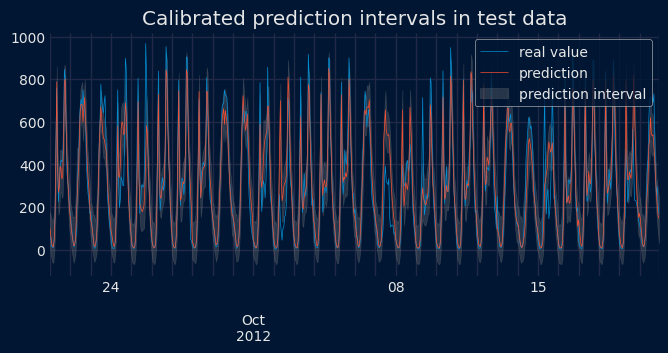

In [12]:
# Plot intervals
# ==============================================================================
predictions_test_calibrated['pred'] = predictions_test['pred']
plot_prediction_intervals(
    predictions         = predictions_test_calibrated,
    y_true              = data_test,
    target_variable     = "users",
    title               = "Calibrated prediction intervals in test data",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
)

# Predicted interval coverage and area (on test data)
# ==============================================================================
coverage = calculate_coverage(
               y_true      = data.loc[end_calibration:, 'users'],
               lower_bound = predictions_test_calibrated["lower_bound"], 
               upper_bound = predictions_test_calibrated["upper_bound"]
           )
area = (predictions_test_calibrated["upper_bound"] - predictions_test_calibrated["lower_bound"]).sum()
print(f"Coverage: {round(100 * coverage, 2)} %")
print(f"Area: {round(area, 2)}")

After calibration, the prediction intervals achieve an empirical coverage very close to the nominal coverage of 80%.

## Calibration for global models

Same process of calibration can be applied to global models. In this case, the `ConformalIntervalCalibrator` transformer is fitted with the calibration intervals of multiple series.

In [4]:
# Data
# ==============================================================================
data = fetch_dataset(name="ett_m2_extended")
data = data.resample(rule="1h", closed="left", label="right").mean()
data = data.loc[:'2017-02-28 23:59:00', :].copy()
data.head(2)

ett_m2_extended
---------------
Data from an electricity transformer station was collected between July 2016 and
July 2018 (2 years x 365 days x 24 hours x 4 intervals per hour = 70,080 data
points). Each data point consists of 8 features, including the date of the
point, the predictive value "Oil Temperature (OT)", and 6 different types of
external power load features: High UseFul Load (HUFL), High UseLess Load (HULL),
Middle UseFul Load (MUFL), Middle UseLess Load (MULL), Low UseFul Load (LUFL),
Low UseLess Load(LULL). Additional variables are created based on calendar
information (year, month, week, day of the week, and hour). These variables have
been encoded using the cyclical encoding technique (sin and cos transformations)
to preserve the cyclical nature of the data.
Zhou, Haoyi & Zhang, Shanghang & Peng, Jieqi & Zhang, Shuai & Li, Jianxin &
Xiong, Hui & Zhang, Wancai. (2020). Informer: Beyond Efficient Transformer for
Long Sequence Time-Series Forecasting.
[10.48550/arXiv.2012.

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,year,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date,,,,,,,,,,,,,,,,
2016-07-01 01:00:00,38.784501,10.88975,34.753500,8.551,4.12575,1.2605,37.83825,2016.0,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.000000,1.000000
2016-07-01 02:00:00,36.041249,9.44475,32.696001,7.137,3.59025,0.6290,36.84925,2016.0,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.258819,0.965926


In [5]:
# Split data into: train-calibration-test
# ==============================================================================
end_train = '2016-11-30 23:59:00'
end_calibration = '2017-01-31 23:59:00'
data_train = data.loc[: end_train, :]
data_cal   = data.loc[end_train:end_calibration, :]
data_test  = data.loc[end_calibration:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates calibration: {data_cal.index.min()} --- {data_cal.index.max()}  (n={len(data_cal)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2016-07-01 01:00:00 --- 2016-11-30 23:00:00  (n=3671)
Dates calibration: 2016-12-01 00:00:00 --- 2017-01-31 23:00:00  (n=1488)
Dates test       : 2017-02-01 00:00:00 --- 2017-02-28 23:00:00  (n=672)


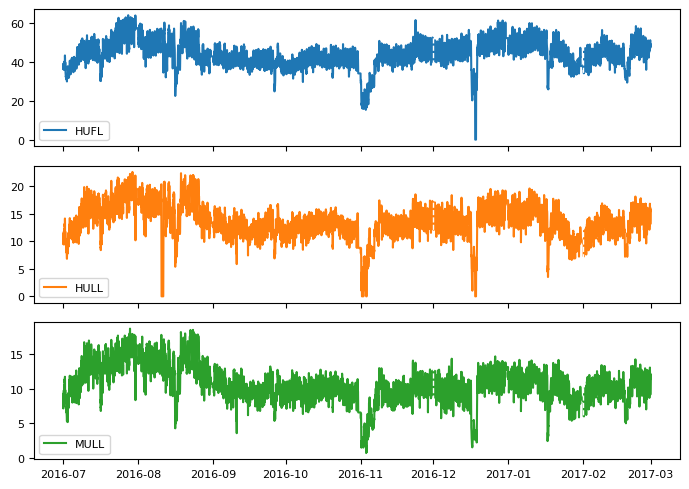

In [16]:
# Plot partitions
# ==============================================================================
series = ['HUFL', 'HULL', 'MULL']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
for i, col in enumerate(series):
    axs[i].plot(data[col], label=col, color=colors[i])
    axs[i].legend(loc='lower left', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train
    axs[i].axvline(pd.to_datetime(end_calibration), color='white', linestyle='--', linewidth=1)  # End validation

plt.tight_layout()

In [7]:
# Create forecaster
# ==============================================================================
exog_features = [
    'year', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'day_of_week_sin',
    'day_of_week_cos', 'hour_sin', 'hour_cos'
]
params = {
    "n_estimators": 50,
    "max_depth": 5
}
lags = [1, 3, 11, 12, 13, 14, 15, 17, 23, 24, 25, 49, 73, 97, 145]
forecaster = ForecasterRecursiveMultiSeries(
                 regressor       = LGBMRegressor(random_state=15926, verbose=-1, **params),
                 lags            = lags,
                 encoding        = 'ordinal',
                 differentiation = 1,
                 binner_kwargs   = {'n_bins': 5}
             )

In [8]:
# Backtesting on test data using in-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         initial_train_size = len(data.loc[:end_calibration, :]),
         steps              = 24,
         differentiation    = 1,
     )

metric_test, predictions_test = backtesting_forecaster_multiseries(
                                  forecaster              = forecaster,
                                  series                  = data.loc[:, series],
                                  exog                    = data.loc[:, exog_features],
                                  cv                      = cv,
                                  metric                  = 'mean_absolute_error',
                                  interval                = [10, 90],
                                  interval_method         = "bootstrapping",
                                  n_boot                  = 150,
                                  use_in_sample_residuals = True,
                                  n_jobs                  = 'auto',
                                  verbose                 = False,
                                  show_progress           = True
                              )

  0%|          | 0/28 [00:00<?, ?it/s]

In [9]:
# Coverage and area for each level
# ==============================================================================
for level in predictions_test["level"].unique():
    predictions_level = (
        predictions_test[predictions_test["level"] == level]
        .drop(columns="level")
        .copy()
    )
    coverage = calculate_coverage(
        y_true=data_test[level],
        lower_bound=predictions_level["lower_bound"],
        upper_bound=predictions_level["upper_bound"],
    )
    area = (predictions_level["upper_bound"] - predictions_level["lower_bound"]).sum()
    print(f"{level} - Coverage: {round(100 * coverage, 2)} % - Area: {round(area, 2)}")

HUFL - Coverage: 88.69 % - Area: 8623.09
HULL - Coverage: 93.75 % - Area: 5119.88
MULL - Coverage: 91.52 % - Area: 3876.66


In this example, eventhough the intervals are calculated using in-sample residuals, the coverage is higher than the nominal coverage of 80%. Next, they are calibrated using the `ConformalIntervalCalibrator` transformer.

In [10]:
# Backtesting on calibration set
# ==============================================================================
cv = TimeSeriesFold(
         initial_train_size = len(data.loc[:end_train, :]),
         steps              = 24,
         differentiation    = 1,
     )

metric_cal, predictions_cal = backtesting_forecaster_multiseries(
                                  forecaster              = forecaster,
                                  series                  = data.loc[:end_calibration, series],
                                  exog                    = data.loc[:end_calibration, exog_features],
                                  cv                      = cv,
                                  metric                  = 'mean_absolute_error',
                                  interval                = [10, 90],
                                  interval_method         = "bootstrapping",
                                  n_boot                  = 150,
                                  use_in_sample_residuals = True,
                                  n_jobs                  = 'auto',
                                  verbose                 = False,
                                  show_progress           = True
                              )

  0%|          | 0/62 [00:00<?, ?it/s]

In [11]:
# Create and fit ConformalIntervalCalibrator
# ==============================================================================
calibrator = ConformalIntervalCalibrator(nominal_coverage=0.8)
calibrator.fit(
    y_true = data_cal[series],
    y_pred_interval = predictions_cal
)
calibrator

ConformalIntervalCalibrator 
Nominal coverage: 0.8 
Correction factor: {'HUFL': -0.3825428679506452, 'HULL': -0.5593634397650742, 'MULL': -0.5952440204394641} 
Fitted series: ['HUFL', 'HULL', 'MULL'] 

The correction factor of all levels is negative, which means that the prediction intervals are too wide and need to be narrowed to achieve the desired coverage probability.

In [12]:
# Calibrate prediction intervals of the test set
# ==============================================================================
predictions_test_calibrated = calibrator.transform(predictions_test)
predictions_test_calibrated.head(3)

,level,lower_bound,upper_bound
2017-02-01 00:00:00,HUFL,34.991128,37.104389
2017-02-01 01:00:00,HUFL,33.300467,36.532882
2017-02-01 02:00:00,HUFL,32.110421,37.048993


HUFL - Coverage: 85.27 % - Area: 8108.95
HULL - Coverage: 89.14 % - Area: 4368.09
MULL - Coverage: 82.44 % - Area: 3076.65


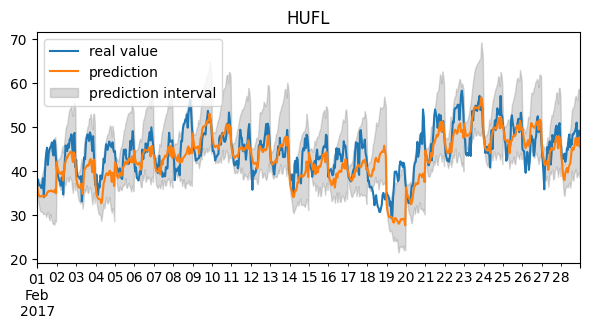

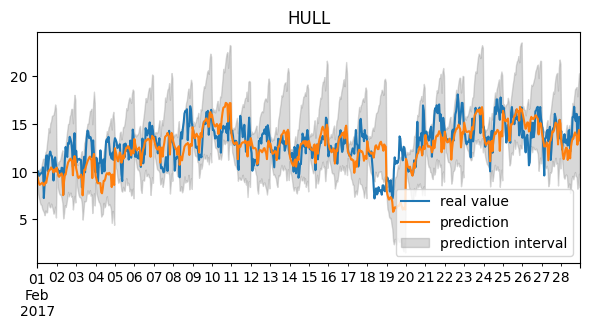

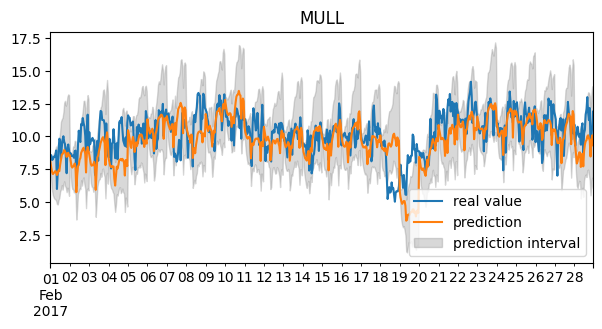

In [13]:
for level in predictions_test_calibrated["level"].unique():
    predictions_level = (
        predictions_test_calibrated[predictions_test_calibrated["level"] == level]
        .drop(columns="level")
        .copy()
    )
    predictions_level['pred'] = predictions_test.loc[predictions_test['level'] == level, 'pred']
        
    plot_prediction_intervals(
        predictions         = predictions_level,
        y_true              = data_test[[level]],
        target_variable     = level,
        title               = level,
        kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
    )
    coverage = calculate_coverage(
        y_true=data_test[level],
        lower_bound=predictions_level["lower_bound"],
        upper_bound=predictions_level["upper_bound"],
    )
    area = (predictions_level["upper_bound"] - predictions_level["lower_bound"]).sum()
    print(f"{level} - Coverage: {round(100 * coverage, 2)} % - Area: {round(area, 2)}")

HUFL - Coverage: 88.69 % - Area: 8623.09
HULL - Coverage: 93.75 % - Area: 5119.88
MULL - Coverage: 91.52 % - Area: 3876.66


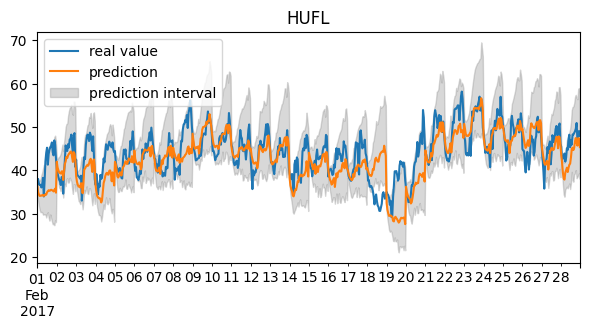

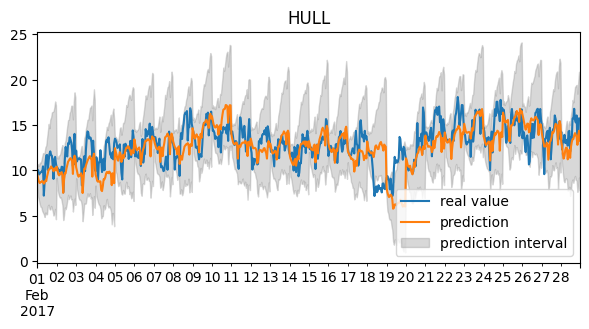

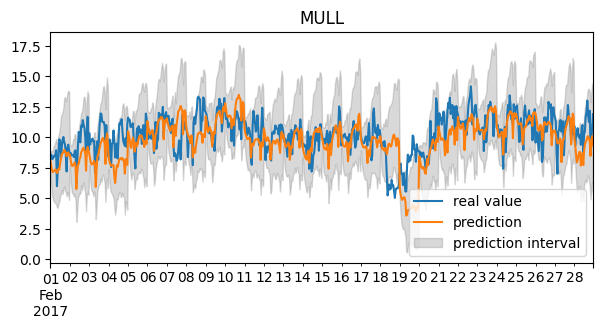

In [14]:
for level in predictions_test["level"].unique():
    predictions_level = (
        predictions_test[predictions_test["level"] == level]
        .drop(columns="level")
        .copy()
    )
    predictions_level['pred'] = predictions_test.loc[predictions_test['level'] == level, 'pred']
        
    plot_prediction_intervals(
        predictions         = predictions_level,
        y_true              = data_test[[level]],
        target_variable     = level,
        title               = level,
        kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
    )
    coverage = calculate_coverage(
        y_true=data_test[level],
        lower_bound=predictions_level["lower_bound"],
        upper_bound=predictions_level["upper_bound"],
    )
    area = (predictions_level["upper_bound"] - predictions_level["lower_bound"]).sum()
    print(f"{level} - Coverage: {round(100 * coverage, 2)} % - Area: {round(area, 2)}")